In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import positioner as ps
import IPython 
import numpy as np
from matplotlib import pyplot
from astropy.table import Table

This notebook presents an estimate of the number of positioner collisions per pointing.

The positioner's geometry is defined from the DESIDoc 8999 v2. Images are taken from the same doc.

There are three types of collisions.

1. Type I: No collision.
2. Type II: The two upper arms (fiber holders) collide
3. Type III: The upper arm of A collides with the body of B.


Example of Type 2 collision

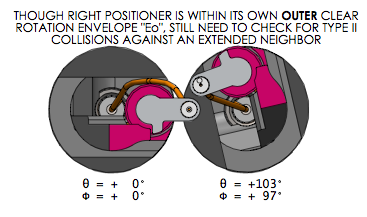

In [18]:
IPython.display.Image("../img/type2_collision.png")

Example of Type 2 collision

Example of Type 3 collision.

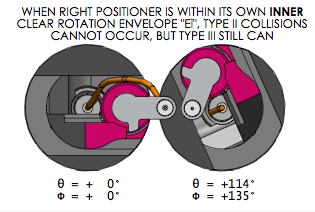

In [19]:
IPython.display.Image("../img/type3_collision.png")

To find the angle between the black line and the axis of symmetry we solve a triangle with known sides.

# Test on poissonian targets

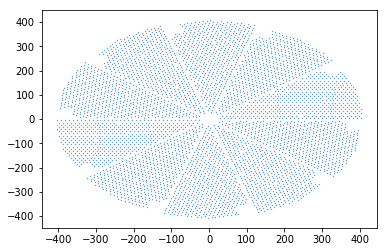

In [20]:
positioner_file = "fiberpos.ecsv"
positioner_data = Table.read(positioner_file, format='ascii.ecsv')
x_pos = positioner_data['X']
y_pos = positioner_data['Y']
z_pos = positioner_data['Z']
pyplot.scatter(x_pos, y_pos, s=0.1)
n_pos = np.size(x_pos)
R1 = 3.0
R2 = 3.0
patrol_radius = R1+R2

In [21]:
def gen_targets(n_pos=5000):
    n_targets = n_pos * 5
    theta_rand = 2.0 * np.pi * np.random.random(n_targets)
    r_rand = 160000.0* np.random.random(n_targets)
    x_t = np.sqrt(r_rand) * np.sin(theta_rand)
    y_t = np.sqrt(r_rand) * np.cos(theta_rand)
    return x_t, y_t

In [22]:
def assign_positioner(x_pos, y_pos, x_t, y_t):
    n_pos = np.size(x_pos)
    n_targets = np.size(x_t)
    x_on_t = np.zeros(n_pos)
    y_on_t = np.zeros(n_pos)
    target_available = np.zeros(n_targets)
    for i in range(n_pos):
        x_pos_i = x_pos[i]
        y_pos_i = y_pos[i]
    
        distance = np.sqrt((x_t-x_pos_i)**2 + (y_t - y_pos_i)**2)
        reachable = np.where((distance<patrol_radius)&(target_available==0))
        reachable = reachable[0]
        n_reachable = np.size(reachable)
    
        if (n_reachable):
            x_on_t[i] = x_target[reachable[0]]
            y_on_t[i] = y_target[reachable[0]]
            target_available[reachable[0]] = -1
        else:
            x_on_t[i] = x_pos_i
            y_on_t[i] = y_pos_i
    return x_on_t, y_on_t


In [23]:
def find_theta_phi(x_pos, y_pos, x_on_t, y_on_t):
    #amount on x and y that each fiber has to move to reach the target
    x_move = x_on_t - x_pos
    y_move = y_on_t - y_pos

    #the corresponding Theta and Phi for each positioner
    r = np.sqrt(x_move**2 + y_move**2) + 1E-12
    cos_alpha = (R2*R2 + R1*R1 - r*r)/(2.0*R2*R1)
    cos_beta = (R1*R1 + r*r - R2*R2)/(2.0*R1*r)
    cos_gamma = (r*r + R2*R2 - R1*R1)/(2.0*r*R2)
    cos_delta = x_move/r

    P = cos_alpha.copy()
    T = cos_alpha.copy()
    P[:] = np.inf
    T[:] = np.inf

    good = np.where(np.abs(cos_gamma)<=1.0)

    T[good] = 2.0*np.pi - np.arccos(cos_beta[good]) - np.arccos(cos_delta[good])
    P[good] = np.pi - np.arccos(cos_alpha[good])

    positive_y = np.where((y_move>=0.0) & (np.abs(cos_gamma)<=1.0))
    T[positive_y] = np.arccos(cos_delta[positive_y]) - np.arccos(cos_beta[positive_y])

    P[good] = np.rad2deg(P[good])
    T[good] = np.rad2deg(T[good])
    return T, P


In [ ]:
n_layers = 20
n_colls = np.zeros(n_layers)
n_colls_random = np.zeros(n_layers)

collided = {}
collided_random = {}

for layer in range(n_layers):
    collided[layer] = []
    collided_random[layer] = []
    #generate targets and do the allocation
    x_target, y_target = gen_targets(n_pos=n_pos)
    x_on_target, y_on_target = assign_positioner(x_pos, y_pos, x_target, y_target)
    T,P = find_theta_phi(x_pos, y_pos, x_on_target, y_on_target)

    #generate the positioners on their final target positions
    pos_list = []
    pos_list_random = []
    for i in range(n_pos):
        pos_list.append(ps.positioner(offset_x=x_pos[i], offset_y=y_pos[i],Theta=T[i], Phi=P[i]))
        pos_list_random.append(ps.positioner(offset_x=x_pos[i], offset_y=y_pos[i],Theta=T[i], Phi=P[i], 
                                         R1=np.random.normal(3.0, 0.1), R2=np.random.normal(3.0,0.1)))
    #check for collisions, both type II and III
    n_collision = 0
    n_collision_random = 0
    for i in range(n_pos):
        x_pos_i = x_pos[i]
        y_pos_i = y_pos[i]
        distance = np.sqrt((x_pos-x_pos_i)**2 + (y_pos - y_pos_i)**2)
        reachable = np.where(distance<patrol_radius*2.1)
        reachable = reachable[0]
        n_reachable = np.size(reachable)
        #we only check for collisions with neighboring positioners
        for j in reachable:
            if(i!=j):
                a, b = ps.find_collision_type(pos_list[i], pos_list[j])
                if(a|b and (i not in collided[layer])):
                    n_collision = n_collision + 1 
                    collided[layer].append(i)
        for j in reachable:
            if(i!=j):
                a, b = ps.find_collision_type(pos_list_random[i], pos_list_random[j])
                if(a|b and (i not in collided_random[layer])):
                    n_collision_random = n_collision_random + 1 
                    collided_random[layer].append(i)
    print(layer, n_collision, n_collision_random)
    n_colls[layer] = n_collision
    n_colls_random[layer] = n_collision_random

In [101]:
case_A = []
case_B = []
case_AB = []
case_B_missed_by_A = [] 
case_A_missed_by_B = [] 
for layer in range(n_layers):
    intersect = set(collided[layer]).intersection(collided_random[layer])
    missed = set(collided_random[layer]) - intersect
    invented = set(collided[layer]) - intersect
    n_case_A = len(set(collided[layer]))
    n_case_B = len(set(collided_random[layer]))
    case_A.append(n_case_A)
    case_B.append(n_case_B)
    case_AB.append(len(intersect))
    case_B_missed_by_A.append(len(missed))
    case_A_missed_by_B.append(len(invented))
    print(n_case_A, n_case_B, len(intersect), len(missed), len(invented))
case_A = np.array(case_A)
case_B = np.array(case_B)
case_AB = np.array(case_AB)
case_B_missed_by_A  = np.array(case_B_missed_by_A)
case_A_missed_by_B  = np.array(case_A_missed_by_B)

582 582 548 34 34
544 560 508 52 36
576 563 535 28 41
549 584 523 61 26
602 617 561 56 41
619 612 572 40 47
546 558 508 50 38
614 618 580 38 34
518 528 492 36 26
602 597 562 35 40


In [102]:
np.mean(case_B_missed_by_A), np.mean(case_A_missed_by_B), np.mean(case_A), np.mean(case_B)

(43.0, 36.299999999999997, 575.20000000000005, 581.89999999999998)

In [43]:
print("{:.2f} percent of positioners are colliding (on average)".format(np.average(100.0*n_colls/n_pos)))
print("{:.2f} percent of positioners are colliding (on average)".format(np.average(100.0*n_colls_random/n_pos)))


11.70 percent of positioners are colliding (on average)
11.85 percent of positioners are colliding (on average)


-7.6 11.6721891691


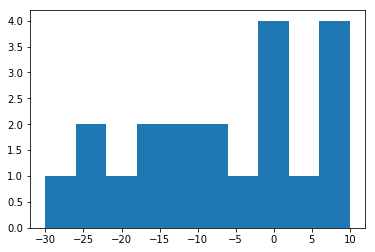

In [55]:
diff_colls = n_colls - n_colls_random
pyplot.hist(diff_colls, bins=10)
print(diff_colls.mean(), diff_colls.std())

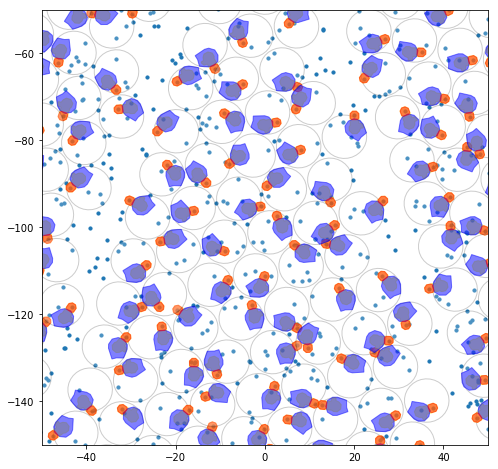

In [39]:
fig, ax = pyplot.subplots(figsize=(8, 8))
ax.set_xlim(-50,50)
ax.set_ylim(-150,-50)
for i in range(5000):
    ps.add_plot_positioner(pos_list[i], ax=ax)
pyplot.scatter(x_target, y_target, s=10)

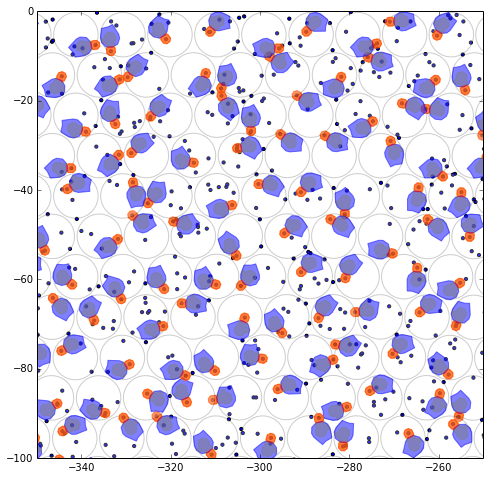

In [36]:
fig, ax = pyplot.subplots(figsize=(8, 8))
ax.set_xlim(-350,-250)
ax.set_ylim(-100,0)
for i in range(2700,3400):
    ps.add_plot_positioner(pos_list[i], ax=ax)
pyplot.scatter(x_target, y_target, s=10)